<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/llibre-estil/logo-UOC-masterbrand-vertical.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2023-2 · Màster universitari en Ciència de Dades (Data Science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC4 Models generatius

**Títol:** GAN condicionada

**Descripció:** Construcció i entrenament d'una GAN condicionada a la classe.

Les xarxes generatives adversàries (GANs) ens permeten generar dades d'imatges, vídeos o àudio a partir d'una entrada aleatòria. Normalment, l'entrada aleatòria es mostreja d'una distribució normal, abans de passar per una sèrie de transformacions que la converteixen en alguna cosa plausible (imatge, vídeo, àudio, etc.).

No obstant això, un simple DCGAN no ens permet controlar l'aparença (per exemple, la classe) de les mostres que estem generant. Per exemple, amb una GAN que genera dígits manuscrits, un simple DCGAN no ens permetria escollir la classe dels dígits que estem generant. Per poder controlar el que generem, necessitem condicionar la sortida de la GAN a una entrada semàntica, com ara la classe d'una imatge.

En aquesta PAC, construirem una GAN Condicional que pugui generar dígits manuscrits condicionats a una classe determinada.





<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Quines aplicacions d'utilitat pot tenir un model com aquest?      
</div>

Principalment aquest model es pot fer servir per aplicacions de generar noves dades sintètiques. Això pot ser util de per si en molts ambits, per exemple en l'art, es pot fer un quadre nou amb l'estil de Dalí o Miró, o amb una mescla dels dos estils. Evidentment això es pot fer servir en marketing, per generar imatges de productes, en videojocs, etc. Una aplicació molt important, i precisament per la Ciencia de dades és la creació de noves imatges per l'entrenament. Per exemple si tenim poques dades i volem generar-ne més, podem utilitzar GANs, i així en augmentar la quantitat de training data, augmentar la accuracy del nostre model. O si el nostre dataset està desbalancejat i tenim menys imatges d'una categoria, el podem balancejar a partir d'imatge sintetiques generades amb GANs.

In [1]:
!pip3 install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## 0. Importacions necessàries

In [2]:
import keras

from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
from sklearn.preprocessing import OneHotEncoder

## 1. Definició de constants i hiperparàmetres

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Per què serveix la variable `latent_dim`?
    
</div>

La latent dimension és un hiperperametre de les GAN. Representa les dimensions del vector que generara el "noise" sintetic per generar noves dades.

Es molt important que tingui les dimensions correctes, un valor gran farà que la GAN pugui aprendre representacions complexes, mentre que un petit farà que s'enfoqui en les features més importants, però no serà capaç de trobar els detalls més petits.

## 2. Càrrega del dataset i preprocessat

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Exercici [1,5 pts.]:</strong> Descarrega i carrega les dades:
</div>

Descarrega el conjunt de dades de la web:
https://www.kaggle.com/datasets/jordidelatorreuoc/handwritten-digits-with-writer-characteristics/data

Utilitzarem la versió de 28x28. Analitza el contingut del conjunt de dades. Identifica les variables d'interès, images en format 28x28 i etiquetes (digits) i carrega-les en un dataset de tensorflow. Les variables s'han de carregar, normalitzar a [0,1]. Les classes s'han de vectoritzar, p.e. classe 9 a [0, 0, 0, 0, 0, 0 ,0 ,0, 1] i les imatges han de tenir les dimensions correctes per ser processades posterioment amb tensorflow.

Les dimensions de sortida haurien de ser:

Shape of images: (13580, 28, 28, 1)

Shape of labels: (13580, 10)

S'espera com a sortida del procés una variable `dataset` del tipus `tf.data.Dataset`

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
# read the npy file
images = np.load('/content/drive/MyDrive/HDW/Images(28x28).npy')

In [17]:
images.shape

(13580, 28, 28)

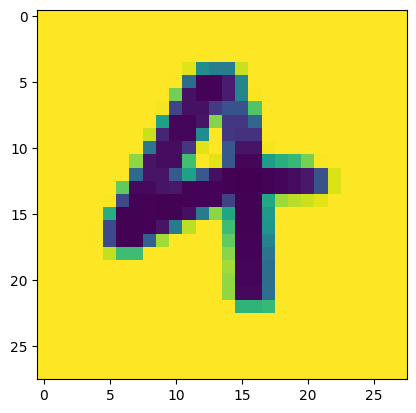

In [20]:
plt.imshow(images[42])

In [11]:
writer_info = images = np.load('/content/drive/MyDrive/HDW/WriterInfo.npy')
writer_info

array([[  1,   0,  29, ...,   0,   2,   1],
       [  1,   0,  29, ...,   0,   2,   1],
       [  1,   0,  29, ...,   0,   2,   1],
       ...,
       [  0, 117,  68, ...,   1,   1,   0],
       [  0, 117,  68, ...,   1,   1,   0],
       [  0, 117,  68, ...,   1,   1,   0]], dtype=int32)

In [12]:
np.unique(writer_info[:,0])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [32]:
# We normalize the images
images = images.astype("float32")/255

In [33]:
images = np.expand_dims(images, axis=-1)

In [34]:
images = images.reshape(-1, 28, 28, 1)

In [35]:
images.shape

(13580, 28, 28, 1)

In [24]:
# We work on the labels
from tensorflow.keras.utils import to_categorical

labels = to_categorical(writer_info[:,0], num_classes=10)

In [25]:
labels

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [27]:
labels.shape

(13580, 10)

In [38]:
# we organize it as a dataset
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

In [36]:
# ESCRIU EL CODI AQUÍ


print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Shape of images: (13580, 28, 28, 1)
Shape of labels: (13580, 10)


## 3. Càlcul del nombre de canals d'entrada per al generador i el discriminador.

En una GAN regular (no condicional), comencem per mostrejar soroll (d'una dimensió fixa) d'una distribució normal. En el nostre cas, també hem de tenir en compte les etiquetes de classe. Haurem d'afegir el nombre de classes als canals d'entrada del generador (entrada de soroll) i també al discriminador (entrada de la imatge generada).

In [37]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Justifica per què serveixen les variables anteriors i quina és la necessitat de cadascuna d'elles      
</div>

La variable generator_in_channels és la suma del latent_dim i el numero de classes. El latent_dim s'ha explicat anteriorment, i el nombre de classes es refereix en el nostre cas a [0,1,2,3,4,5,6,7,8,9], per tant 10 classes.

El discriminador_in_channels en canvi es el nombre de classes (10) més el nombre de canals de les nostres imatges. En aquest cas com que les imatges son en escala de grisos doncs es 1.

## 4. Implementació del Generador i el Discriminador

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [3 pts.]:</strong>
Desenvolupeu un model de Deep Learning utilitzant Keras per a generar imatges d'una base de dades específica. El vostre objectiu és construir un discriminador i un generador que formin part d'una xarxa antagonista generativa (GAN). El discriminador ha de ser capaç de distingir entre imatges reals i les generades pel generador, mentre que el generador ha de crear imatges que el discriminador no pugui distingir com a falses. Utilitzeu les capes de convolució, activació i denses per construir els models de manera que compleixin amb les dimensions especificades de les entrades i sortides. Assegureu-vos de gestionar adequadament les dimensions de les capes convolucionals i transconvolucionals per obtenir les dimensions de sortida desitjades. Després de la creació dels models, podeu entrenar la GAN per generar imatges que siguin visuals i realistes. Heu de fer recerca online per generar la vosta proposta. Les variables associades al discriminador i el generador resultants s'hauran de dir `generator` i `discriminator`.

</div>

In [40]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


In [41]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [43]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# define early stopper
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss', patience=5, restore_best_weights=True)

history = cond_gan.fit(dataset, epochs=200, callbacks=[early_stopping])


Epoch 1/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - d_loss: 0.0758 - g_loss: 3.5939
Epoch 2/200
 22/213 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - d_loss: 0.0558 - g_loss: 3.6843

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `loss` which is not available. Available metrics are: d_loss,g_loss
  current = self.get_monitor_value(logs)


213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.0505 - g_loss: 3.8056
Epoch 3/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.0406 - g_loss: 4.1417
Epoch 4/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.0337 - g_loss: 4.4000
Epoch 5/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.0319 - g_loss: 4.5478
Epoch 6/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.0330 - g_loss: 4.7120
Epoch 7/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.2055 - g_loss: 3.8093
Epoch 8/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.5583 - g_loss: 1.6017
Epoch 9/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.4971 - g_loss: 1.4249
Epoch 10/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.5122 - g_loss: 1.3551
Epoch 11/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5452 - g_loss: 1.2620
Epoch 12/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - d_loss: 0.5533 - g_loss: 1.2093
Epoch 13/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste


Generem un grafic per veure 10 imatges sintetiques de cada un dels labels:

In [71]:
# We first extract the trained generator from our Conditional GAN
trained_gen = cond_gan.generator

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


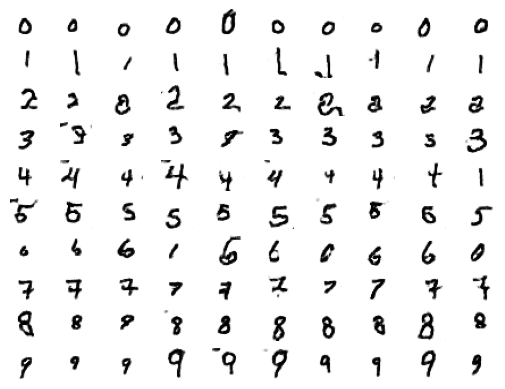

In [75]:
# Number of images to generate per class
num_images_per_class = 10

# Iterate over each class
for class_label in range(num_classes):
    # Sample noise
    noise = np.random.normal(0, 1, (num_images_per_class, latent_dim))

    # Create one-hot encoded class labels
    labels = to_categorical([class_label] * num_images_per_class, num_classes)

    # Combine noise and labels
    noise_and_labels = np.concatenate([noise, labels], axis=1)

    # Generate images
    fake_images = trained_gen.predict(noise_and_labels)

    # Create figure
    for i in range(num_images_per_class):
        plt.subplot(num_classes, num_images_per_class, class_label * num_images_per_class + i + 1)
        plt.imshow(fake_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

plt.show()


## 5. Implementació de la classe model `ConditionalGAN`

En base a la definició de la classe següent respon a les preguntes de sota:

In [77]:

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data

        # apartat 1
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # apartat 2
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # apartat 3
        generated_images = self.generator(random_vector_labels)

        # apartat 4
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        # apartat 5
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)

        # apartat 6
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # apartat 7
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # apartat 8
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # apartat 9
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # apartat 10
        misleading_labels = ops.zeros((batch_size, 1))

        # apartat 11
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # apartat 12
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [2,5 pts.]</strong>
Omple la taula següent indicant el que significa cadascun dels apartats del codi:      
</div>

| Apartat   | Descripció  |
|-----------|-------------|
| Apartat 1 | Prepara les one-hot encoded classes per les imatges reals convertintlos via repeticio en les mateixes dimensions que les imatges. D'aquesta manera es podran concatenar i cada pixel tindra un label associat |
| Apartat 2 | Generem els vectors latents aleatoris, que seran el soroll que es concatena a les classes |
| Apartat 3 | El generador crea les imatges sintetiques |
| Apartat 4 | Preparacio de les imatges sintetiques i el labels per al discriminador |
| Apartat 5 | Prepara les imatges reals amb els corresponents one-hot labels per al discriminador |
| Apartat 6 | Combina les imatges reals i les sintetiques en un batch per poder-ho donar al discriminador |
| Apartat 7 | Es crea una variable labels que conté labels "1" per la imatge real i "0" per la imatge sintètica |
| Apartat 8 | Entrenament del discriminador, fent servir la loss function per calcular els gradients i actualizar els weights |
| Apartat 9 | Tornem a generear random_latent vectors i labels (Similar al pas 2) |
| Apartat 10| Genera labels per confondre al discriminador, on tots els labels corresponen a imatges sintetiques |
| Apartat 11| Actualitza el generador perquè pugui generar noves imatges més dificils de distingir pel discriminador. Genera noves imatges falses, les concatena amb labels, les passa al discriminador i calcula la loss function i actualitza els pesos (weights) del generador |
| Apartat 12| Actualitza i retorna les metriques de les funcions de perdua (loss functions) |



## 6. Entrenament de la GAN condicional

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]:</strong> Entrena la xarxa mitjançant el codi que segueix. A continuació executa el codi que permetrà l'us de la xarxa entrenada per generar diferents instàncies de classes diferents i construir un GIF animat que mostra la transició entre les imatges de diferent classe. No cal implementar res. Si els apartats anteriors s'han implementat correctament hauria d'executar-se sense problemes.
</div>

In [78]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - d_loss: 0.6483 - g_loss: 0.8370
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6229 - g_loss: 0.8369
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6253 - g_loss: 0.8308
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6269 - g_loss: 0.8293
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6251 - g_loss: 0.8409
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6300 - g_loss: 0.8412
Epoch 7/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6216 - g_loss: 0.8487
Epoch 8/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6266 - g_loss: 0.8317
Epoch 9/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6234 - g_loss: 0.8424
Epoch 10/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6275 - g_loss: 0.8392
Epoch 11/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - d_loss: 0.6241 - g_loss: 0.8377
Epoch 12/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

In [99]:
trained_gen = cond_gan.generator


num_interpolation = 10

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 3
end_class = 8

fake_images = interpolate_class(start_class, end_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


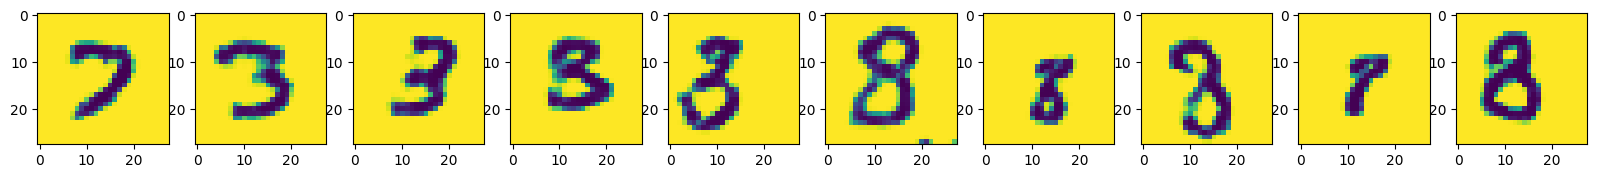

In [100]:
fig, axes = plt.subplots(ncols=len(fake_images), figsize=(20,4))
for i, image in enumerate(fake_images):
  axes[i].imshow(image)
plt.show()


Aqui es visualitza la transicio del numero 3 al 8:


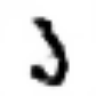

In [86]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")


## 7. Interpolació entre classes utilitzant el generador que hem entrenat

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong>
Finalment, executa el codi següent. Si l'entrenament s'ha dut a terme correctament hauria der ser capaç de generar interpolacions d'imatges entre imatges generades de diferents classes.    
</div>

Es podria millorar el rendiment d'aquest model amb receptes com WGAN-GP. La generació condicional també s'utilitza àmpliament en moltes arquitectures modernes de generació d'imatges com VQ-GANs i DALL-E, entre d'altres.

In [89]:
# extraiem el generador entrenat del nostre GAN Condicional
trained_gen = cond_gan.generator

# tria el nombre d'imatges intermèdies que es generarien entre la interpolació + 2 (imatges inicial i final).
num_interpolation = 9

# soroll per a la interpolació
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # converteix les etiquetes inicial i final a vectors one-hot.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # calcula el vector d'interpolació entre les dues etiquetes.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # combina el soroll i les etiquetes i executa la inferència amb el generador.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 2  # primera classe d'interpolació
end_class = 6  # última classe d'interpolació

fake_images = interpolate_class(start_class, end_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Aquí, primer mostrem soroll d'una distribució normal i després ho repetim per a num_interpolation vegades i donem forma al resultat en conseqüència. Després, el distribuïm uniformement per a num_interpolation amb les etiquetes presents proporcionalment.


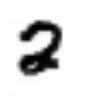

In [90]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Pregunta [0,5 pts.]</strong>
Comentar els resultats dels punts 6 i 7:     
</div>

En l'apartat 6 hem entrenat el model i despres hem creat un objecte geneador a partir del model entrenat. Hem generat imatges sintetiques del numero 3 i 8 per veure com transicionava d'un numero a l'altre en 10 interpolacions. En l'apartat 7 hem fet el mateix pero transicionant del numero 2 al 6, amb 9 interpolacions. Hem fet un gif per visualitzar-ho de forma animada.